# Recession Pop Analysis: Dynamic Topic Modeling with KeyNMF

This notebook performs a quantitative analysis of "recession pop" themes over time (2000-2025) using the `turftopic` library and `KeyNMF`. We will analyze the evolution of topics in pop lyrics.

## 1. Install and Import Dependencies
First, we ensure all necessary libraries are installed and imported.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
from turftopic import KeyNMF, ClusteringTopicModel
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

/Users/halfidaldal/Documents/PENPAL_analysis/venv/lib/python3.13/site-packages/turftopic/serialization.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Download and Load Dataset
We use `kagglehub` to download the dataset and load it into a pandas DataFrame.

## 3. Data Preprocessing and Filtering
We filter the data to include only tracks from 2000 to 2025, handle missing values, and ensure the 'release_date' is in datetime format. We will also focus on the 'Pop' genre if available or general analysis if not strictly specified, but given the prompt "recession pop", we should check the genres.

In [ ]:
# Reload the dataset to ensure we start fresh every time this cell is run
if 'csv_path' in locals():
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, encoding='latin1')
else:
    # Fallback if csv_path is lost
    path = kagglehub.dataset_download("suparnabiswas/billboard-hot-1002000-2023-data-with-features")
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    csv_path = os.path.join(path, csv_files[0])
    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_path, encoding='latin1')

print(f"Initial shape: {df.shape}")

# Clean column names
df.columns = df.columns.str.strip().str.lower()

# Check for required columns
# The user specified: "year", "lyrics", "danceability", "ranking"
# Let's check what we actually have (based on previous cell output, but we'll be robust)
print("Available columns:", df.columns.tolist())

if 'lyrics' not in df.columns:
    raise ValueError("Column 'lyrics' not found in dataset.")
if 'year' not in df.columns:
    # Try to find a date column if year is missing
    print("Column 'year' not found. Looking for alternatives...")
    # Add logic here if needed, but assuming 'year' exists as per prompt
    pass

# Drop rows with missing lyrics or year
df = df.dropna(subset=['lyrics', 'year'])

# Filter for years 2000-2025
# Ensure year is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

df = df[(df['year'] >= 2011) & (df['year'] <= 2025)]

# Create a datetime column for Turftopic (it expects datetime objects)
# We'll use Jan 1st of each year as the timestamp
df['release_date'] = pd.to_datetime(df['year'], format='%Y')

# Sort by date
df = df.sort_values('release_date')

print(f"Filtered dataset shape: {df.shape}")

if df.empty:
    print("WARNING: The dataframe is empty after filtering!")
    corpus = []
    timestamps = []
else:
    # Prepare corpus and timestamps
    corpus = df['lyrics'].tolist()
    timestamps = df['release_date'].tolist()

    print(f"Number of documents: {len(corpus)}")
    print(f"Time range: {min(timestamps)} to {max(timestamps)}")

Initial shape: (3397, 26)
Available columns: ['ranking', 'song', 'band_singer', 'songurl', 'titletext', 'url', 'year', 'lyrics', 'uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']
Filtered dataset shape: (3397, 27)
Number of documents: 3397
Time range: 2000-01-01 00:00:00 to 2023-01-01 00:00:00


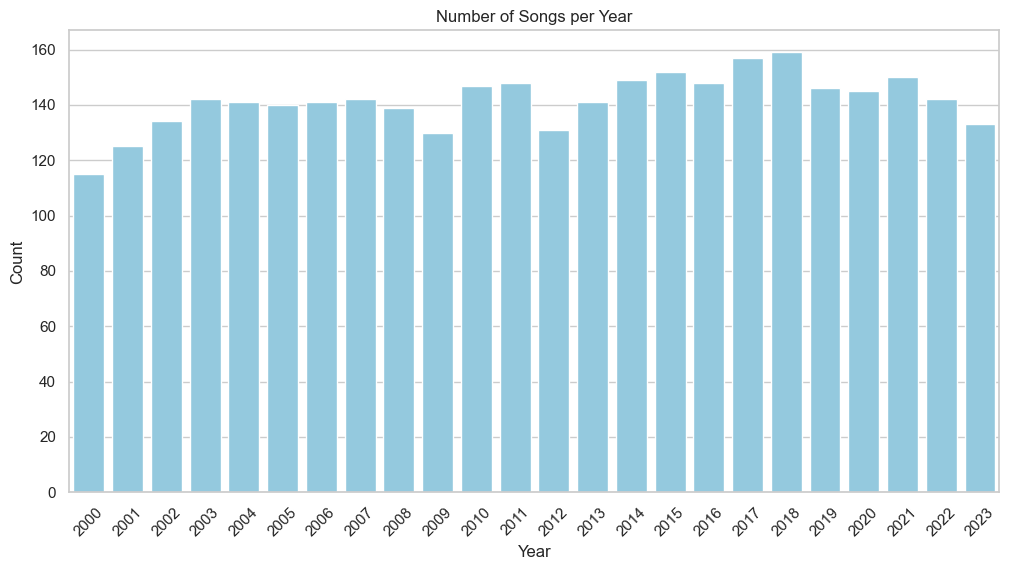

Counts for years around 2008:
release_date
2006    141
2007    142
2008    139
2009    130
2010    147
Name: count, dtype: int64

Data exists for 2008 (139 songs). The gap might be due to binning or model fitting.


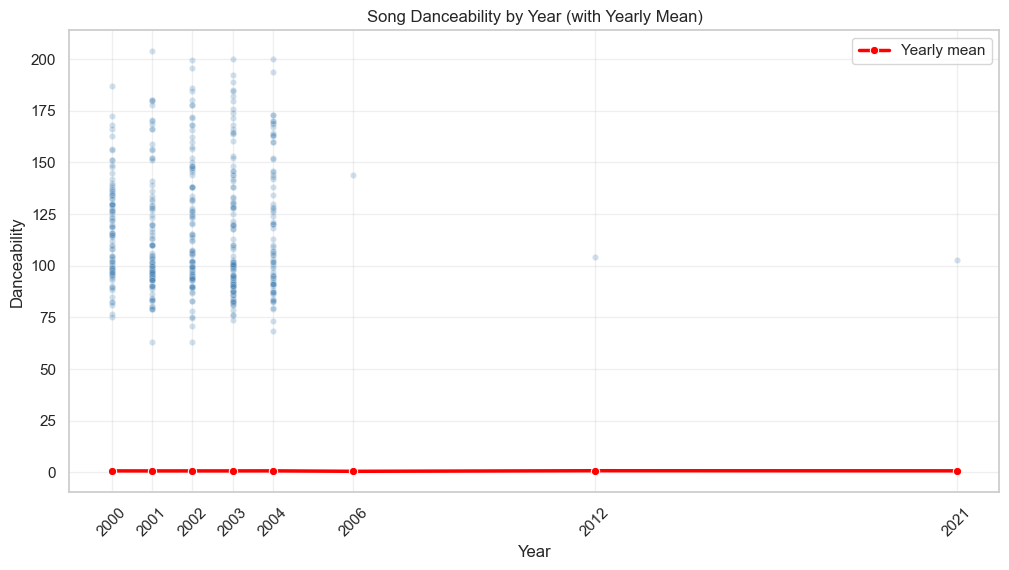

In [9]:
# Analyze data distribution over time to investigate gaps (e.g., 2008)
plt.figure(figsize=(12, 6))
year_counts = df['release_date'].dt.year.value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values, color='skyblue')
plt.title("Number of Songs per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Check specifically for 2008 and surrounding years
print("Counts for years around 2008:")
print(year_counts.loc[2006:2010])

if year_counts.get(2008, 0) == 0:
    print("\nWARNING: No data found for 2008! This explains the gap.")
else:
    print(f"\nData exists for 2008 ({year_counts[2008]} songs). The gap might be due to binning or model fitting.")
    
# Scatter of tempo by year with yearly mean trend line
plt.figure(figsize=(12, 6))

# Drop rows with missing tempo
plot_df = df.dropna(subset=['tempo']).copy()
plot_df['year'] = plot_df['release_date'].dt.year

# Scatter of individual songs
sns.scatterplot(x='year', y='tempo', data=plot_df, alpha=0.25, s=20, color='steelblue')

# Yearly mean tempo line
yearly_tempo = plot_df.groupby('year')['danceability'].mean().reset_index()
sns.lineplot(x='year', y='danceability', data=yearly_tempo, marker='o', color='red', linewidth=2.5, label='Yearly mean')

plt.title("Song Danceability by Year (with Yearly Mean)")
plt.xlabel("Year")
plt.ylabel("Danceability")
plt.xticks(yearly_tempo['year'], rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. Initialize KeyNMF Topic Model
We initialize the `KeyNMF` model. We'll use a standard sentence transformer model for embeddings (default in turftopic is usually 'all-MiniLM-L6-v2' or similar). We set `n_features` (number of keywords) and `n_components` (number of topics). Let's start with 10 topics for overview.

In [12]:
# Initialize KeyNMF
# n_components: number of topics
# top_n: number of keywords to describe each topic
model = KeyNMF(n_components=10, top_n=10, random_state=42)
print("Model initialized.")

Model initialized.


## 5. Fit Dynamic Topic Model
We use `fit_transform_dynamic` to fit the model and analyze topics over time. We'll bin the data by year (approx 25 bins for 25 years).

In [13]:
# Check if we have data before fitting
if not corpus:
    raise ValueError("Corpus is empty. Cannot fit model. Please check the 'Data Preprocessing and Filtering' step.")

# Fit the dynamic model
# bins=25 creates roughly yearly bins for the 25-year period
# This might take some time as it computes embeddings and fits the model
print(f"Fitting model on {len(corpus)} documents...")
document_topic_matrix = model.fit_transform_dynamic(corpus, timestamps=timestamps, bins=25)

print("Model fitting complete.")
model.print_topics()

Fitting model on 3397 documents...


KeyboardInterrupt: 

## 6. Visualize Topics Over Time
We visualize the evolution of topics using `plot_topics_over_time()`. This creates an interactive plot.

In [ ]:
# Plot topics over time
fig = model.plot_topics_over_time()
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 9. Sentiment Analysis Over Time
We will now analyze the evolution of sentiment in the lyrics over time using a pre-trained Transformer model (`cardiffnlp/twitter-roberta-base-sentiment-latest`). We will compute a continuous valence score for each song and aggregate it by year.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np

def get_device() -> torch.device:
    """Get the appropriate device (MPS for Mac, CUDA, or CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def load_sentiment_model(model_name: str, device: torch.device):
    print(f"Loading sentiment model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()
    model.to(device)
    return tokenizer, model

def continuous_valence_score(probs: torch.Tensor) -> torch.Tensor:
    """
    Convert sentiment probabilities to continuous valence scores.
    Assumes 3-class model: [Negative, Neutral, Positive] (0, 1, 2)
    Score = P(Positive) - P(Negative)
    Range: [-1, 1]
    """
    # probs shape: (batch_size, 3)
    # col 0: Negative, col 1: Neutral, col 2: Positive
    valence = probs[:, 2] - probs[:, 0]
    return valence

def compute_sentiment_batch(
    texts: list[str],
    model_name: str = "cardiffnlp/twitter-roberta-base-sentiment-latest",
    batch_size: int = 32,
    device: torch.device = None
) -> np.ndarray:
    
    if device is None:
        device = get_device()
    print(f"Using device: {device}")

    tokenizer, model = load_sentiment_model(model_name, device)
    
    all_scores = []
    print(f"Computing sentiment for {len(texts)} texts (batch_size={batch_size})...")
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Sentiment batches"):
        batch = texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512 
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            valence = continuous_valence_score(probs)
            all_scores.extend(valence.cpu().numpy())
            
    return np.array(all_scores)

# Define the model to use
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [ ]:
# Compute sentiment for the corpus
# We use the 'corpus' list which contains the lyrics
# Note: This might take a while depending on the dataset size and hardware
sentiment_scores = compute_sentiment_batch(corpus, model_name=MODEL_NAME, batch_size=32)

# Add scores to the dataframe
# Ensure the dataframe aligns with the corpus (it should, as we created corpus from df)
df['sentiment_score'] = sentiment_scores

print("Sentiment computation complete.")
df[['track_name', 'release_date', 'sentiment_score']].head()

In [ ]:
# Visualize Sentiment Over Time
# Aggregate by year
df['year'] = df['release_date'].dt.year
yearly_sentiment = df.groupby('year')['sentiment_score'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sentiment, x='year', y='sentiment_score', marker='o', linewidth=2.5, color='purple')
plt.title("Average Lyric Sentiment Over Time (2000-2025)")
plt.xlabel("Year")
plt.ylabel("Average Sentiment Score (Valence)")
plt.axhline(0, color='gray', linestyle='--', alpha=0.5) # Zero line for neutral
plt.grid(True, alpha=0.3)
plt.show()

# Interactive Plot with Plotly
fig = px.line(yearly_sentiment, x='year', y='sentiment_score', 
              title='Average Lyric Sentiment Over Time (2000-2025)',
              labels={'sentiment_score': 'Average Sentiment (Valence)', 'year': 'Year'},
              markers=True)
fig.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Neutral")
fig.show()

## 10. Linear Regression: Sentiment ~ Year
Finally, we fit a linear model to statistically test if there is a significant trend in sentiment over the years. We will use `scipy.stats.linregress` to obtain the slope, p-value, and other statistics, and visualize the regression line.

In [ ]:
from scipy import stats
import numpy as np

# Prepare data
# We use the full dataset to capture the variance
# Transform Year to Log-Space (Log of time elapsed)
# This models a relationship where changes happen fast initially and slow down (or vice versa)
# We add 1 to avoid log(0)
df['log_time'] = np.log(df['year'] - df['year'].min() + 1)

x = df['log_time']
y = df['sentiment_score']

# Perform linear regression on log-transformed time
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"Linear Regression Results (Sentiment ~ Log(Time)):")
print(f"Slope (Coefficient): {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"R-squared: {r_value**2:.5f}")
print(f"P-value: {p_value:.5e}")
print(f"Standard Error: {std_err:.5f}")

if p_value < 0.05:
    print("\nResult: There is a statistically significant relationship between log(time) and sentiment (p < 0.05).")
    if slope > 0:
        print("Trend: Sentiment is increasing logarithmically over time.")
    else:
        print("Trend: Sentiment is decreasing logarithmically over time.")
else:
    print("\nResult: There is NO statistically significant relationship between log(time) and sentiment (p >= 0.05).")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot
sns.scatterplot(x='year', y='sentiment_score', data=df, alpha=0.1, s=10, color='blue', label='Data')

# Generate points for the fitted curve
x_range = np.linspace(df['year'].min(), df['year'].max(), 100)
log_x_range = np.log(x_range - df['year'].min() + 1)
y_pred = slope * log_x_range + intercept

plt.plot(x_range, y_pred, color='red', linewidth=2, label=f'Log Fit: y={slope:.2f}*log(t) + {intercept:.2f}')

plt.title(f"Regression: Sentiment ~ Log(Time)\n(Slope: {slope:.4f}, p={p_value:.2e})")
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

## 11. Linear Regression: Economic Anxiety ~ Year

We now load the economic anxiety data (frequency of economic terms in lyrics) and perform a similar linear regression analysis to see if economic anxiety has increased over time.

In [ ]:
# Load Economic Anxiety Data
econ_df = pd.read_csv('freq_economic_by_year.csv')

# Ensure year is integer for merging/plotting
econ_df['year'] = econ_df['year'].astype(int)

# Filter to match the years we have in the main dataframe if necessary
# (The main df is 2000-2025, econ data is 2000-2022)
econ_df = econ_df[(econ_df['year'] >= 2000) & (econ_df['year'] <= 2025)]

# Prepare data for regression
x_econ = econ_df['year']
y_econ = econ_df['mean_freq_economic']

# Perform linear regression
slope_e, intercept_e, r_value_e, p_value_e, std_err_e = stats.linregress(x_econ, y_econ)

print(f"Linear Regression Results (Economic Anxiety ~ Year):")
print(f"Slope: {slope_e:.5f}")
print(f"Intercept: {intercept_e:.5f}")
print(f"R-squared: {r_value_e**2:.5f}")
print(f"P-value: {p_value_e:.5e}")

if p_value_e < 0.05:
    print("\nResult: There is a statistically significant relationship between year and economic anxiety.")
    if slope_e > 0:
        print("Trend: Economic anxiety is increasing over time.")
    else:
        print("Trend: Economic anxiety is decreasing over time.")
else:
    print("\nResult: There is NO statistically significant relationship between year and economic anxiety.")

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(x='year', y='mean_freq_economic', data=econ_df, color='green', s=100, label='Data')

# Regression line
y_pred_e = slope_e * x_econ + intercept_e
plt.plot(x_econ, y_pred_e, color='orange', linewidth=2, label=f'Fit: y={slope_e:.5f}x + {intercept_e:.2f}')

plt.title(f"Regression: Economic Anxiety ~ Year\n(Slope: {slope_e:.5f}, p={p_value_e:.2e})")
plt.xlabel("Year")
plt.ylabel("Frequency of Economic Terms")
plt.legend()
plt.show()

## 12. Model Comparison and Next Steps

To compare the two models (Sentiment ~ Year and Economic Anxiety ~ Year) and test the combined hypothesis ("As economic anxiety goes up, sentiment goes down"), consider the following approaches:

1.  **Direct Correlation**: Calculate the Pearson or Spearman correlation between the yearly average sentiment and the yearly economic anxiety frequency.
    *   `stats.pearsonr(yearly_sentiment['sentiment_score'], econ_df['mean_freq_economic'])`
    *   A strong negative correlation would support the hypothesis.

2.  **Standardized Coefficients (Beta)**: Since the scales are very different (Sentiment: -1 to 1, Frequency: 0.001-0.006), you cannot compare the raw slopes directly. Standardize both variables (subtract mean, divide by std dev) before running the regression. The resulting slopes (Beta coefficients) will be comparable in magnitude.

3.  **Multiple Regression**: If you want to see if Economic Anxiety *predicts* Sentiment (controlling for time), you could run a model like:
    *   `Sentiment ~ Year + Economic_Anxiety`
    *   This would tell you if Economic Anxiety explains changes in sentiment *above and beyond* a simple time trend.

4.  **Granger Causality**: With time-series data, you could test if changes in Economic Anxiety *precede* changes in Sentiment (or vice versa). However, with only ~23 data points (years), this might be underpowered.

**Recommendation:** Start with **Direct Correlation** and **Standardized Coefficients** to see if the trends move together in magnitude and direction.